# Project Objective
```create a model that yielding best performance on prediction that can predict customer's sentiment with the focus on the negative sentence```

In [1]:
# @hidden_cell 
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='f7324497-c88c-4a70-9cc8-c7131d1e3a43', project_access_token='p-62cd455dfa72dca94d48b0ec16ad7b3b68590005')
pc = project.project_context

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,TfidfTransformer
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.naive_bayes import ComplementNB,MultinomialNB,BaseNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import NMF,TruncatedSVD,PCA

In [3]:
# @hidden_cell
import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0


# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

if os.environ.get('RUNTIME_ENV_LOCATION_TYPE') == 'external':
    endpoint_547e2e471367434c9459f69f91f6aa92 = 'https://s3-api.us-geo.objectstorage.softlayer.net'
else:
    endpoint_547e2e471367434c9459f69f91f6aa92 = 'https://s3-api.us-geo.objectstorage.service.networklayer.com'

client_547e2e471367434c9459f69f91f6aa92 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='jW6BhhdTNkDn5zeEv94r_efxkTgG6oaKQxzPK5x-NoLa',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url=endpoint_547e2e471367434c9459f69f91f6aa92)

body = client_547e2e471367434c9459f69f91f6aa92.get_object(Bucket='kevindsoncloud-donotdelete-pr-9ks0ppvkgsay2l',Key='Tweets.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )




In [4]:
df = pd.read_csv(body)
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [6]:
def missing_percentage():
    naval = df.isnull().sum() / len(df) * 100
    naval = naval[naval.values > 0]
    naval = naval.sort_values(ascending=False)
    return naval
    

In [7]:
missing_percentage()

negativereason_gold          99.781421
airline_sentiment_gold       99.726776
tweet_coord                  93.039617
negativereason               37.308743
user_timezone                32.923497
tweet_location               32.329235
negativereason_confidence    28.128415
dtype: float64

In [8]:
df = df.drop(['negativereason_gold','airline_sentiment_gold','tweet_coord'],axis=1)
fill_mode= ['negativereason','user_timezone','tweet_location']
df['negativereason'] = df['negativereason'].fillna(value=df['negativereason'].mode()[0])
df['user_timezone'] = df['user_timezone'].fillna(value=df['user_timezone'].mode()[0])
df['tweet_location'] = df['tweet_location'].fillna(value=df['tweet_location'].mode()[0])
df['negativereason_confidence'] = df['negativereason_confidence'].fillna(value=np.mean(df['negativereason_confidence'].mode()[0]))

In [9]:
missing_percentage()

Series([], dtype: float64)

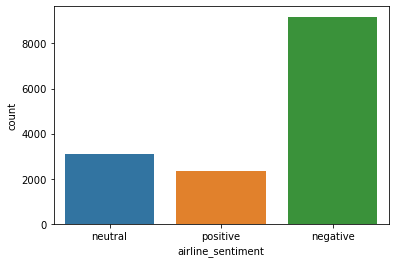

In [10]:
sns.countplot(df['airline_sentiment'])

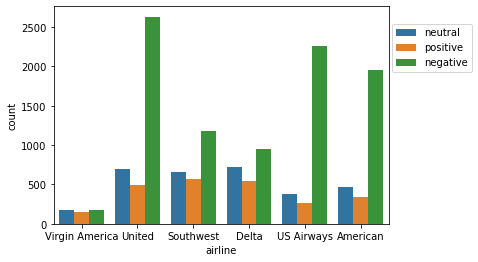

In [11]:
sns.countplot(df['airline'],hue=df['airline_sentiment'])
plt.gca().legend(loc=[1.01,0.7])

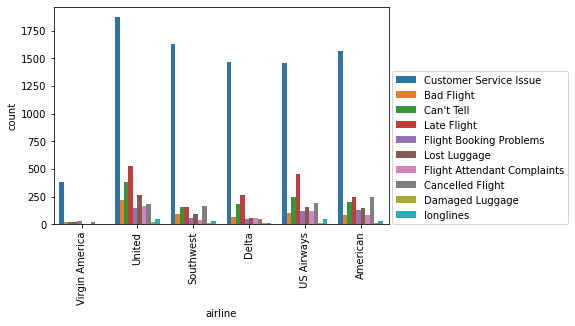

In [12]:
sns.countplot(data=df, x='airline', hue='negativereason' )
plt.xticks(rotation=90)
plt.legend(loc=[1.01,.0])
plt.show()

In [13]:
data = df[['text','airline_sentiment']]
X = data['text']
y = data['airline_sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42,stratify=y)

In [14]:
#pipelining
def ml_pipeline(algo,param_grid):
    preprocess = Pipeline(steps=[
        ('tfidf',TfidfVectorizer(stop_words='english')),
        ('dim_red',TruncatedSVD(n_components=3000)),
        ('algo',algo)
    ])
    search = GridSearchCV(preprocess,param_grid=param_grid)
    return preprocess,search

In [15]:
base,search = ml_pipeline(LogisticRegression(),param_grid={'algo__max_iter':[3000],'algo__C':[10,25],'algo__penalty':['l2'],'algo__solver':['sag']})
search.fit(X_train,y_train)

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


GridSearchCV(estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words='english')),
                                       ('dim_red',
                                        TruncatedSVD(n_components=3000)),
                                       ('algo', LogisticRegression())]),
             param_grid={'algo__C': [10, 25], 'algo__max_iter': [3000],
                         'algo__penalty': ['l2'], 'algo__solver': ['sag']})

In [16]:
search.best_score_

0.7704116117347196

In [17]:
search.best_params_

{'algo__C': 10,
 'algo__max_iter': 3000,
 'algo__penalty': 'l2',
 'algo__solver': 'sag'}

In [18]:
logreg_pred = search.predict(X_test)

In [16]:
from sklearn.metrics import classification_report,confusion_matrix,plot_confusion_matrix,plot_roc_curve

              precision    recall  f1-score   support

    negative       0.84      0.89      0.87      1377
     neutral       0.59      0.58      0.58       465
    positive       0.74      0.60      0.66       354

    accuracy                           0.78      2196
   macro avg       0.72      0.69      0.70      2196
weighted avg       0.77      0.78      0.77      2196



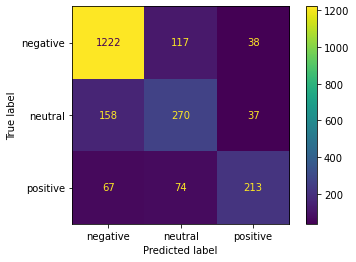

In [20]:
print(classification_report(y_test,logreg_pred))
plot_confusion_matrix(search,X_test,y_test)

In [27]:
from joblib import dump,load
filename = "logreg_nlp_86.joblib"
dump(search,filename)

['logreg_nlp_86.joblib']

In [14]:
#pipelining
def ml_pipeline_nmf(algo,param_grid):
    preprocess = Pipeline(steps=[
        ('tfidf',TfidfVectorizer(stop_words='english')),
        #('dim_red',NMF(n_components=100,max_iter=200,init='nndsvda',solver='cd')),
        ('algo',algo)
    ])
    search = GridSearchCV(preprocess,param_grid=param_grid)
    return preprocess,search

0.6776763418204086
              precision    recall  f1-score   support

    negative       0.67      1.00      0.80      1377
     neutral       0.74      0.14      0.24       465
    positive       0.85      0.14      0.24       354

    accuracy                           0.68      2196
   macro avg       0.75      0.43      0.43      2196
weighted avg       0.72      0.68      0.59      2196



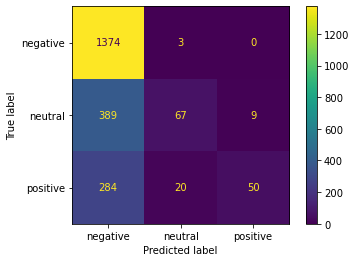

In [17]:
base2,search2 = ml_pipeline_nmf(MultinomialNB(),param_grid={'algo__alpha':[1]})
search2.fit(X_train,y_train)
print(search2.best_score_)
cnb_ypred = search2.predict(X_test)

print(classification_report(y_test,cnb_ypred))
plot_confusion_matrix(search2,X_test,y_test)

In [ ]:
base3,search3 = ml_pipeline(RandomForestClassifier(max_depth=3,max_features='log2'),param_grid={'algo__n_estimators':[100,250,400]})
search3.fit(X_train,y_train)
print(search3.best_score_)
rfc_ypred = search3.predict(X_test)

print(classification_report(y_test,rfc_ypred))
plot_confusion_matrix(search3,X_test,y_test)

In [ ]:
from joblib import load,dump
filename= "MNB model.joblib"
dump(search2,filename)

In [15]:
#X_train_tfidf
#do not call todense() otherwise will crash the RAM

<12444x13414 sparse matrix of type '<class 'numpy.float64'>'
	with 113879 stored elements in Compressed Sparse Row format>

In [ ]:
print("modeling complete")

# model deployment

### import and install model dependencies

In [21]:
#!pip install -U ibm-watson-machine-learning

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 1.8 MB 19.6 MB/s eta 0:00:01
  Attempting uninstall: ibm-watson-machine-learning
    Found existing installation: ibm-watson-machine-learning 1.0.70
    Uninstalling ibm-watson-machine-learning-1.0.70:
      Successfully uninstalled ibm-watson-machine-learning-1.0.70


In [19]:
from ibm_watson_machine_learning import APIClient
import json
import requests

### authenticate and setup space

In [20]:
# @hidden_cell
#setup url and apikey from IAM cloud
wml_credentials = {
    'apikey':'LNvz40yDrciF6SS9-tmBpCUrq9E-nWRYz1jANiwkeOFc',
    'url':'https://us-south.ml.cloud.ibm.com',
}

#instancing
wml_client = APIClient(wml_credentials)
wml_client.spaces.list()

Note: 'limit' is not provided. Only first 50 records will be displayed if the number of records exceed 50
------------------------------------  -----------------------------------------------------------  ------------------------
ID                                    NAME                                                         CREATED
088e8207-5409-44e3-9e74-bb40dd1fc3cb  openscale-express-path-29b4037c-8782-4487-a68f-31138ee36300  2021-05-17T16:22:12.655Z
8d7a3de9-5607-48b5-8ad6-0eed0263ea38  NLP_airline_sentiment                                        2021-05-17T02:23:19.122Z
------------------------------------  -----------------------------------------------------------  ------------------------


In [21]:
#choose default deployment space
SPACE_ID = '8d7a3de9-5607-48b5-8ad6-0eed0263ea38'
wml_client.set.default_space(SPACE_ID)

'SUCCESS'

## Save and deploy model

In [137]:
# set choosen model
MODEL_NAME = 'SKLEARN_MNB_sentiment'
DEPLOYMENT_NAME = 'sklearn_nlp'
BEST_MODEL = search2

In [138]:
#set python version
software_spec_uid = wml_client.software_specifications.get_id_by_name('default_py3.7')

#set model metadata
model_props = {
    wml_client.repository.ModelMetaNames.NAME : MODEL_NAME,
    wml_client.repository.ModelMetaNames.TYPE : 'scikit-learn_0.23',
    wml_client.repository.ModelMetaNames.SOFTWARE_SPEC_UID : software_spec_uid
}

# store model in the cloud instance
model_details = wml_client.repository.store_model(model=BEST_MODEL,
                                                 meta_props=model_props,
                                                 training_data=X_train.to_numpy().reshape([-1,1]),
                                                 training_target=y_train)

In [30]:
#X_train.to_numpy().reshape([-1,1])

In [145]:
# grab model detail properties
model_details

{'entity': {'label_column': 'airline_sentiment',
  'software_spec': {'id': 'e4429883-c883-42b6-87a8-f419d64088cd',
   'name': 'default_py3.7'},
  'training_data_references': [{'connection': {'access_key_id': 'not_applicable',
     'endpoint_url': 'not_applicable',
     'secret_access_key': 'not_applicable'},
    'id': '1',
    'location': {},
    'schema': {'fields': [{'name': 'f0', 'type': 'str'}],
     'id': '1',
     'type': 'ndarray'},
    'type': 's3'}],
  'type': 'scikit-learn_0.23'},
 'metadata': {'created_at': '2021-05-18T08:23:25.563Z',
  'id': 'dfff1d5a-410c-4620-a106-ae3cc882f151',
  'modified_at': '2021-05-18T08:23:28.176Z',
  'name': 'SKLEARN_MNB_sentiment',
  'owner': 'IBMid-55000AM5BB',
  'space_id': '8d7a3de9-5607-48b5-8ad6-0eed0263ea38'},
 'system': {'warnings': []}}

In [146]:
#grab choosen model uid from cloud
model_uid = wml_client.repository.get_model_uid(model_details)
model_uid

'dfff1d5a-410c-4620-a106-ae3cc882f151'

In [147]:
#set deployment meta data
deployment_props = {wml_client.deployments.ConfigurationMetaNames.NAME :DEPLOYMENT_NAME,
                    wml_client.deployments.ConfigurationMetaNames.ONLINE : {}}

#deploy
deployment = wml_client.deployments.create(artifact_uid=model_uid,
                                          meta_props=deployment_props)
deployment



#######################################################################################

Synchronous deployment creation for uid: 'dfff1d5a-410c-4620-a106-ae3cc882f151' started

#######################################################################################


initializing
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='daf9dbfe-25a7-4dd4-a8bc-7085f44f3a83'
------------------------------------------------------------------------------------------------




{'entity': {'asset': {'id': 'dfff1d5a-410c-4620-a106-ae3cc882f151'},
  'custom': {},
  'deployed_asset_type': 'model',
  'hardware_spec': {'id': 'Not_Applicable', 'name': 'S', 'num_nodes': 1},
  'name': 'sklearn_nlp',
  'online': {},
  'space_id': '8d7a3de9-5607-48b5-8ad6-0eed0263ea38',
  'status': {'online_url': {'url': 'https://us-south.ml.cloud.ibm.com/ml/v4/deployments/daf9dbfe-25a7-4dd4-a8bc-7085f44f3a83/predictions'},
   'state': 'ready'}},
 'metadata': {'created_at': '2021-05-18T09:29:05.074Z',
  'id': 'daf9dbfe-25a7-4dd4-a8bc-7085f44f3a83',
  'modified_at': '2021-05-18T09:29:05.074Z',
  'name': 'sklearn_nlp',
  'owner': 'IBMid-55000AM5BB',
  'space_id': '8d7a3de9-5607-48b5-8ad6-0eed0263ea38'}}

In [40]:
#X_test.to_numpy().tolist()

In [91]:
# @hidden_cell
deploy_id = 'c85369f5-7f28-43dc-8233-919b28111249'
model_endpoint = 'https://us-south.ml.cloud.ibm.com/ml/v4/deployments/cbdd7b23-b001-4ae0-83c8-7399077d7f48/predictions'


# NOTE: you must manually set API_KEY below using information retrieved from your IBM Cloud account.
API_KEY = "LNvz40yDrciF6SS9-tmBpCUrq9E-nWRYz1jANiwkeOFc"
token_response = requests.post('https://iam.cloud.ibm.com/identity/token', data={"apikey": API_KEY, "grant_type": 'urn:ibm:params:oauth:grant-type:apikey'})
mltoken = token_response.json()["access_token"]

header = {'Content-Type': 'application/json', 'Authorization': 'Bearer ' + mltoken}

# NOTE: manually define and pass the array(s) of values to be scored in the next line
payloads = {'input_data':[{'fields':X_test.to_frame().columns.to_numpy().tolist(),'values':X_test.values.reshape(-1,1).tolist()}]}

response_scoring = requests.post('https://us-south.ml.cloud.ibm.com/ml/v4/deployments/cbdd7b23-b001-4ae0-83c8-7399077d7f48/predictions?version=2021-05-17', json=payloads, headers={'Authorization': 'Bearer ' + mltoken})
print("Scoring response")
print(response_scoring.json())

Scoring response
{'predictions': [{'fields': ['prediction', 'probability'], 'values': [['negative', [0.8421031394365839, 0.09994896277988934, 0.05794789778352746]]]}]}


In [92]:
len(X_test.to_numpy().reshape(-1,1).tolist())
len(X_test.values.reshape(-1,1).tolist())

2196

In [118]:
json.loads(response_scoring.text)['predictions'][0]['values']

[['negative', [0.8421031394365839, 0.09994896277988934, 0.05794789778352746]]]

In [120]:
#response_scoring.text
pred_value = json.loads(response_scoring.text)
preds = np.squeeze(json.loads(response_scoring.text)['predictions'][0]['values'])
len(preds)

2

# attempt 2 scoring

In [148]:
deployment_uid = wml_client.deployments.get_id(deployment)
mod_enpoint = wml_client.deployments.get_scoring_href(deployment)

In [150]:
result = wml_client.deployments.score(deployment_uid,payloads)
result

{'predictions': [{'fields': ['prediction', 'probability'],
   'values': [['negative',
     [0.8421031394365839, 0.09994896277988934, 0.05794789778352746]]]}]}